# Mini-Project Numerical Scientific Computing

* Understand the mathematical algorithm and how it can be programmed.
* Naive algorithm: Make a first implementation in Python using for-loops. You can use either lists or numpy arrays for data storage, but no vector operations.
* Numpy vectorized algorithm: Instead of looping over every element, use Numpy vectorized operations.

Inspiration taken from:
https://beej.us/blog/data/mandelbrot-set/, https://en.wikipedia.org/wiki/Mandelbrot_set

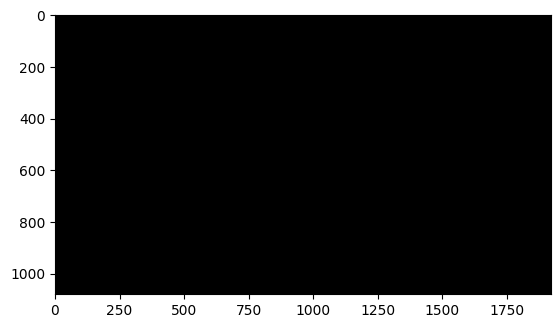

In [1]:
# Importing libraries
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Defining variables for the img
width = 1920
height = 1080
channel = 3
img = np.zeros((height,width,3), dtype=np.uint8)
plt.imshow(img)

In [2]:
# Defining the range of values for
# the real and imaginary parts of c
min_real = -2.0
max_real = 1.0
min_imaginary = -1.5
max_imaginary = 1.5

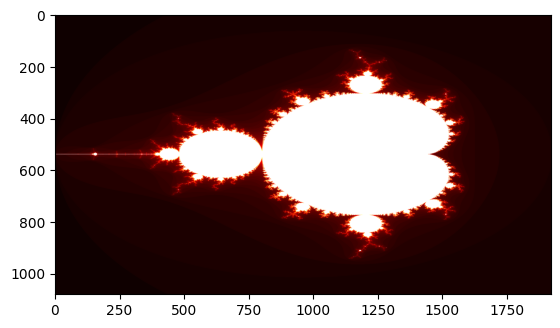

In [3]:
# Main loop
# Pseudocode from wikipedia: https://en.wikipedia.org/wiki/Mandelbrot_set
# Iterate through each pixel coordinate
for Px in range(width):
    for Py in range(height):
        # Map pixel coordinates to real and imaginary parts of c
        c_Real = min_real + (max_real - min_real) * (Px / width)
        c_Imgy = min_imaginary + (max_imaginary - min_imaginary) * (Py / height)
        
        # Initialize z as 0
        z_Real = 0
        z_Imgy = 0
        
        # Initialize iterations and max iterations
        iter = 0
        max_iter = 100
        
        # Calculate the Mandelbrot iteration until the threshold
        # has been reached at 2 and iterations reach max iterations.
        # The threshold has been reached when the magnitude at each
        # calculation is <= to 2. (2*2) represent the squared threshold.
        while(z_Real*z_Real + z_Imgy*z_Imgy <= (2*2) and iter < max_iter):
            # Calculate the next iteration of the real and imginary part of z
            next_z_Real = z_Real*z_Real - z_Imgy*z_Imgy + c_Real
            next_z_Imgy = 2 * z_Real * z_Imgy + c_Imgy
            
            # Assign the calculated parts to z as the new starting point
            z_Real = next_z_Real
            z_Imgy = next_z_Imgy
            
            # Increase iteration
            iter += 1
        
        # Check if iterations has reached max iterations
        # apply color black if yes, otherwise choose color
        # based on the current number of iterations
        """
        if iter == max_iter:
            color = 0 # Black
        else:
            color = 255 - int(iter * 255 / max_iter)
        """
        
        # Normalize the iterations and map the color
        normalized_iter = iter / max_iter
        color = plt.cm.hot(normalized_iter)
        
        # Paint the pixel based on the color
        #img[Py,Px] = (color, color, color)
        img[Py,Px] = (color[0]*255, color[1]*255, color[2]*255)
        

plt.imshow(img)

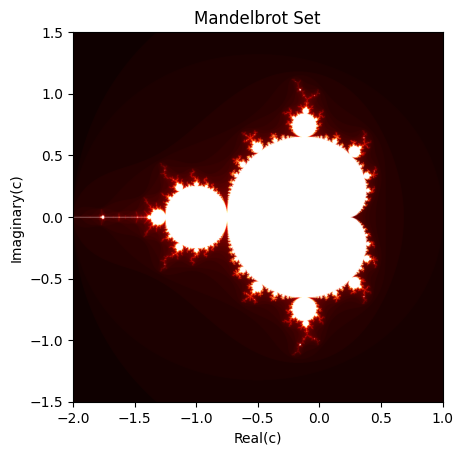

In [4]:
# Display the image
plt.imshow(img, extent=(min_real, max_real, min_imaginary, max_imaginary))
plt.xlabel('Real(c)')
plt.ylabel('Imaginary(c)')
plt.title('Mandelbrot Set')
plt.show()